In [60]:
import numpy
import os
import cv2
import time
import matplotlib.pyplot
from PIL import Image
from tensorflow import keras
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [61]:
width = 160
height = 60
TRAIN_DATA = 'lane_data'
VAL_DATA = 'lane_data/val'

Xtrain =[]
Ytrain = []
# one-host encoding
dict = {'right': [1, 0], 'wrong': [0, 1]}

In [62]:
def rotate_image(image, label):
    list_image = []
    list_label = []
    count = 0
    center = (width // 2, height // 2)
    for distance in range (-8, 10, 2):
        translated_image = cv2.warpAffine(image, numpy.float32([[1, 0, distance], [0, 1, 0]]) , (width, height))
        for degrees in range(-15, 20, 5):
            distance_rotated_image = cv2.warpAffine(translated_image, cv2.getRotationMatrix2D(center, degrees, 1.0), (width, height))
            list_image.append(distance_rotated_image)
            list_label.append(label)
            count = count + 1
    return list_image, list_label

In [63]:
def ReadData(file):
    Data = []
    Label = []
    label = ''
    for folderName in os.listdir(file):
        filename_path = os.path.join(file, folderName)
        list_filename_sub_path = []
        label = folderName
        for filename_sub in os.listdir(filename_path):
            if (".jpg" in filename_sub or ".png" in filename_sub):
                filename_sub_path = os.path.join(filename_path, filename_sub)
                img = numpy.array(Image.open(filename_sub_path))
                img = cv2.resize(img, (width, height))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                list_rotate_image, list_label = rotate_image(img, dict[(label)])
                list_filename_sub_path.extend(list_rotate_image)
                Label.extend(list_label)
        Data.extend(list_filename_sub_path)
    return Data, Label


In [64]:
# Đọc dữ liệu từ TRAIN_DATA
Xtrain, Ytrain = ReadData(TRAIN_DATA)

# Chia dữ liệu thành tập huấn luyện và tập validation
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.3, random_state=42)

In [65]:
from tensorflow.keras.losses import MeanSquaredError


model = models.Sequential([
    layers.Conv2D(4, (3, 3), input_shape=(height, width, 1), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.15),
    
    layers.Conv2D(8, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(16, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(2000, activation = 'relu'),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(500, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(2, activation = 'softmax'),
])

model.summary()
adam = Adam(learning_rate=0.001, beta_1=0.9)
# model.compile(optimizer='SGD',
#                              loss='mse',
#                              metrics=['accuracy'])

# Compile the model with MeanSquaredError loss function
model.compile(optimizer='SGD',
              loss=MeanSquaredError(),
              metrics=['accuracy'])

early_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta= 0 , patience=10, verbose=1, mode="auto")

# history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain), validation_data = (numpy.array(Xval), numpy.array(Yval)), epochs=300, batch_size=1200,
#                          callbacks = [early_callback],
#                          verbose=True)

from tensorflow.keras.callbacks import CSVLogger

# Định nghĩa callback CSVLogger để lưu loss và accuracy vào file CSV
csv_logger = CSVLogger('training_log.csv', separator=',', append=False)

# Huấn luyện mô hình với callback CSVLogger
history = model.fit(numpy.array(Xtrain), numpy.array(Ytrain),
                    validation_data=(numpy.array(Xval), numpy.array(Yval)),
                    epochs=300, batch_size=1200,
                    callbacks=[early_callback, csv_logger],
                    verbose=True)

model.save('model_trained.h5')

c:\Users\teahu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 58, 158, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 27, 77, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 11, 36, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2000)           │     2,882,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,435,306 (20.73 MB)

 Trainable params: 5,435,306 (20.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 823ms/step - accuracy: 0.5503 - loss: 0.4182 - val_accuracy: 0.5529 - val_loss: 0.4411
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 807ms/step - accuracy: 0.5745 - loss: 0.4109 - val_accuracy: 0.7384 - val_loss: 0.2098
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 739ms/step - accuracy: 0.7111 - loss: 0.2547 - val_accuracy: 0.6944 - val_loss: 0.2841
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - accuracy: 0.7218 - loss: 0.2533 - val_accuracy: 0.7766 - val_loss: 0.1839
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step - accuracy: 0.7555 - loss: 0.2179 - val_accuracy: 0.7875 - val_loss: 0.1884
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 726ms/step - accuracy: 0.7730 - loss: 0.2003 - val_accuracy: 0.8078 - val_loss: 0.1645
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 824ms/step - accuracy: 0.7659 - loss: 0.2040 - val_accuracy: 0.8052 - val_loss: 0.1724
Epoch 8/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7797 - loss: 0.1931 - val_accu

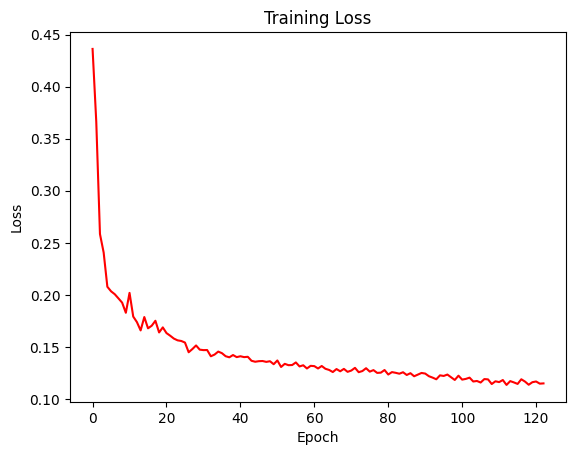

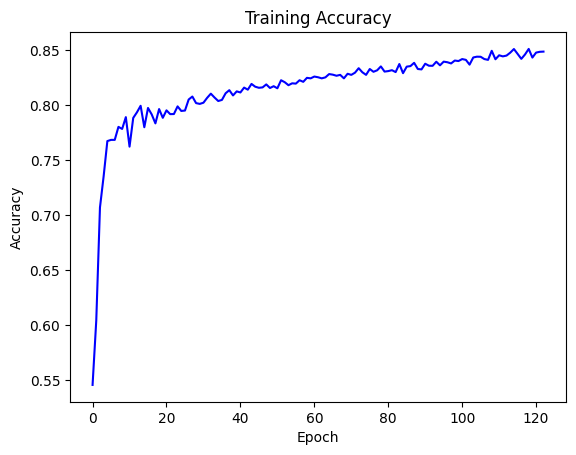

In [69]:

# print(history.history.keys())
# matplotlib.pyplot.plot(history.history['loss'], color='red')
# # matplotlib.pyplot.plot(history.history)
# # matplotlib.pyplot.title('model m')
# matplotlib.pyplot.ylabel('loss')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()
# # summarize history for loss mse
# matplotlib.pyplot.plot(history.history['accuracy'], color='blue')
# matplotlib.pyplot.ylabel('accuracy')
# matplotlib.pyplot.xlabel('epoch')
# matplotlib.pyplot.show()

import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
log_data = pd.read_csv('training_log.csv')

# Vẽ biểu đồ loss qua các epoch
plt.plot(log_data['loss'], color='red')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Vẽ biểu đồ accuracy qua các epoch
plt.plot(log_data['accuracy'], color='blue')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


In [88]:
dict = {'true': [1, 0], 'false': [0, 1]}
name_result = ['right', 'wrong']

# load model
modelTrained = keras.models.load_model('./model_trained.h5')

modelTrained.summary()

# dự đoán
# predict = modelTrained.predict(numpy.array(Xval))

img = numpy.array(Image.open('lane_data/wrong/result_39.jpg'))

def result(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = name_result[numpy.argmax(modelTrained.predict(image.reshape(-1, height, width, 1)))]
    return result

print(result(img))




Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 58, 158, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 29, 79, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 27, 77, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 38, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 11, 36, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 18, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2000)           │     2,882,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1000)           │     2,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 500)            │       500,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,435,308 (20.73 MB)

 Trainable params: 5,435,306 (20.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
wrong
